In [1]:
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate, Reshape, ReLU, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

import transformer_layers
import util_layers
import swin_layers
import utils

2024-02-10 05:25:20.564015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 05:25:20.564076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 05:25:20.565726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
smooth = 1.0

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [3]:
def focal_loss(predict, true):
    error = tf.keras.losses.categorical_crossentropy(predict, true)
    pt = tf.exp(-error)
    focal_loss = (1 - pt) ** 2 * error
    return tf.reduce_mean(focal_loss)

# def mean_iou(predict, true):
#     predict = tf.argmax(predict, axis=-1)
#     true = tf.argmax(true, axis=-1)
#     return tf.keras.metrics.MeanIoU(num_classes=1)(predict, true)

In [ ]:
# model = models.swin_unet_2d((256, 256, 3), filter_num_begin=32,
#                                n_labels=1, depth=4, stack_num_down=2, stack_num_up=2,
#                                patch_size=(4, 4), num_heads=[4, 8, 8, 8],
#                                window_size=[4, 2, 2, 2], num_mlp=156, 
#                                output_activation='Softmax', shift_window=True,
#                                name='swin_unet')
# model.summary()

In [4]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return tf.keras.utils.to_categorical(target_array)

In [5]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X

In [6]:
def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    """ Output """
    output = Conv2D(2, kernel_size=1, padding="same", use_bias=False, activation="softmax")(X)
#     print(output.shape)
    
    model = Model(inputs = [input_tensor,], outputs = [output,], name = "Swin_Unet")
    
    return model

In [7]:
filter_num_begin = 64     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of network; depth=4 means four downsampling swin transformer levels 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per downsampling level
window_size = [4, 2, 2, 2] # the size of attention window per downsampling level
num_mlp = 256              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

In [8]:
input_size = (256, 256, 3)
IN = Input(input_size)

# Base architecture
model = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up,
                          patch_size, num_heads, window_size, num_mlp, 
                          shift_window=shift_window, name='swin_unet')
model.summary()

Model: "Swin_Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 patch_extract (patch_extra  (None, 4096, 48)             0         ['input_1[0][0]']             
 ct)                                                                                              
                                                                                                  
 patch_embedding (patch_emb  (None, 4096, 64)             265280    ['patch_extract[0][0]']       
 edding)                                                                                          
                                                                                          

In [9]:
# model.compile(optimizer=Adam(1e-2, clipvalue=0.5), loss=[dice_coef_loss], metrics=[dice_coef, iou_coef, "accuracy"])
model.compile(optimizer=Adam(1e-2, clipvalue=0.5), loss=[focal_loss], metrics=[dice_coef, iou_coef, "accuracy"])
# model.compile(optimizer=Adam(1e-2, clipvalue=0.5), loss=tf.keras.losses.categorical_crossentropy)

In [10]:
imgs_train = np.load("/kaggle/input/brain-dataset-a-unsharp-only/imgs_Train.npy")
imgs_mask_train = np.load("/kaggle/input/brain-dataset-a-unsharp-only/imgs_mask_Train.npy")

imgs_train.shape, imgs_mask_train.shape

((2452, 256, 256, 3), (2452, 256, 256))

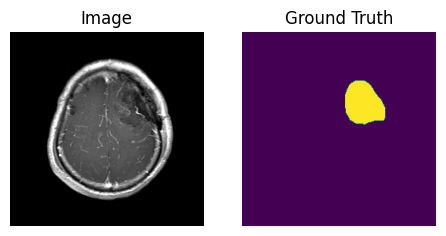

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(5.5,3.5))
ax1.imshow(imgs_train[30].astype("int"))
ax1.set_title("Image")
ax1.set_axis_off()
ax2.imshow(imgs_mask_train[30])
ax2.set_title("Ground Truth")
ax2.set_axis_off()
plt.show()

In [12]:
imgs = imgs_train
imgs_mask = imgs_mask_train
imgs_mask = imgs_mask[..., np.newaxis]
imgs_mask = imgs_mask // 255.0

imgs.shape, imgs_mask.shape

((2452, 256, 256, 3), (2452, 256, 256, 1))

In [13]:
print(imgs.min(), imgs.max(), imgs_mask.min(), imgs_mask.max())
print(np.unique(imgs_mask))

0 255 0.0 1.0
[0. 1.]


In [14]:
imgs_ = input_data_process(imgs)
print(imgs_.min(), imgs_.max())

# mean = np.mean(imgs_)  # mean for data centering
# std = np.std(imgs_)  # std for data normalization

# imgs_ -= mean
# imgs_ /= std

# print(imgs_.min(), imgs_.max())

0.0 1.0


In [15]:
# imgs_mask_ = imgs_mask
imgs_mask_ = target_data_process(imgs_mask)
print(imgs_mask_.shape)
print(imgs_mask_.min(), imgs_mask_.max())
print(np.unique(imgs_mask_))

(2452, 256, 256, 2)
0.0 1.0
[0. 1.]


In [16]:
train_samples = np.ceil( imgs.shape[0] * 0.9).astype("int")
val_samples = imgs.shape[0] - train_samples
# train_samples, val_samples

imgs_tr = imgs_[ : train_samples, :, :, :]
imgs_mask_tr = imgs_mask_[ : train_samples, :, :, :]

imgs_val = imgs_[train_samples : , :, :, :]
imgs_mask_val = imgs_mask_[train_samples : , :, :, :]

imgs_tr.shape, imgs_mask_tr.shape, imgs_val.shape, imgs_mask_val.shape

((2207, 256, 256, 3),
 (2207, 256, 256, 2),
 (245, 256, 256, 3),
 (245, 256, 256, 2))

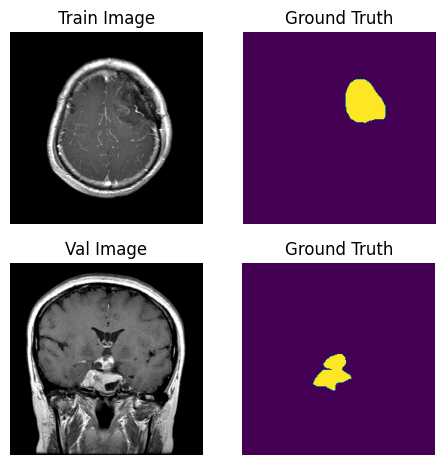

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(5.5,5.5))
ax[0,0].imshow(imgs_tr[30])
ax[0,0].set_title("Train Image")
ax[0,0].set_axis_off()
ax[0,1].imshow(imgs_mask_tr[30, ..., 1])
ax[0,1].set_title("Ground Truth")
ax[0,1].set_axis_off()
ax[1,0].imshow(imgs_val[25])
ax[1,0].set_title("Val Image")
ax[1,0].set_axis_off()
ax[1,1].imshow(imgs_mask_val[25, ..., 1])
ax[1,1].set_title("Ground Truth")
ax[1,1].set_axis_off()
plt.show()

In [18]:
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     shear_range=0.1,
                     horizontal_flip=True,
                     fill_mode='reflect')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(imgs_, augment=True, seed=seed)
mask_datagen.fit(imgs_mask_, augment=True, seed=seed)

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:2093: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2452, 256, 256, 2) (2 channels).
  warnings.warn(


In [19]:
train_image_generator = image_datagen.flow(imgs_tr,  seed=42)
train_mask_generator = mask_datagen.flow(imgs_mask_tr,  seed=42)
# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)

val_image_generator = image_datagen.flow(imgs_val,  seed=42)
val_mask_generator = mask_datagen.flow(imgs_mask_val,  seed=42)
# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2207, 256, 256, 2) (2 channels).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (245, 256, 256, 2) (2 channels).
  warnings.warn(


In [ ]:
# train_data = zip(imgs_tr, imgs_mask_tr)
# valid_data = zip(imgs_val, imgs_mask_val)

In [20]:
fname = "/kaggle/working/swin_unet_weights.h5"

model_checkpoint = ModelCheckpoint(filepath=fname, monitor="val_loss",mode=min, save_best_only=True,verbose=1)
model_earlystop = EarlyStopping(monitor="val_loss",mode=min,min_delta=0.001,patience=50,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, mode=min, min_lr=0.000001, patience=5, verbose=1)
    
history = model.fit(imgs_tr,imgs_mask_tr,
                    batch_size=32, epochs=20, verbose=1, shuffle=False,
                    validation_data=(imgs_val, imgs_mask_val), steps_per_epoch=train_samples//32,
                    validation_steps=val_samples//32,
                    callbacks=[model_checkpoint,model_earlystop,reduce_lr])

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 2847.6638 - dice_coef: 0.7088 - iou_coef: 0.5986 - accuracy: 0.7090
Epoch 1: val_loss improved from inf to 566.71436, saving model to /kaggle/working/swin_unet_weights.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 95s 1s/step - loss: 2847.6638 - dice_coef: 0.7088 - iou_coef: 0.5986 - accuracy: 0.7090 - val_loss: 566.7144 - val_dice_coef: 0.7320 - val_iou_coef: 0.5773 - val_accuracy: 0.7320 - lr: 0.0100
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 98.7667 - dice_coef: 0.8737 - iou_coef: 0.7964 - accuracy: 0.8738
Epoch 2: val_loss improved from 566.71436 to 14.81522, saving model to /kaggle/working/swin_unet_weights.h5
68/68 [==============================] - 91s 1s/step - loss: 98.7667 - dice_coef: 0.8737 - iou_coef: 0.7964 - accuracy: 0.8738 - val_loss: 14.8152 - val_dice_coef: 0.9925 - val_iou_coef: 0.9852 - val_accuracy: 0.9925 - lr: 0.0100
Epoch 3/20
68/68 [==============================] - ETA: 0s - loss: 21.8643 - dice_coef: 0.9100 - iou_coef: 0.8489 - accuracy: 0.9100
Epoch 3: val_loss improved from 14.81522 to 5.86048, saving model to /kaggle/working/swin_unet_weights.h5
68/68 [==============================] - 91s 1s/step - 

In [21]:
imgs_test = np.load("/kaggle/input/brain-dataset-a-unsharp/imgs_Test.npy")
imgs_id_test = np.load("/kaggle/input/brain-dataset-a-unsharp/imgs_mask_Test.npy")

imgs_test.shape, imgs_id_test.shape

((613, 256, 256, 3), (613, 256, 256))

In [22]:
imgs_te = input_data_process(imgs_test)
print(imgs_te.min(), imgs_te.max())

# mean = np.mean(imgs_te)  # mean for data centering
# std = np.std(imgs_te)  # std for data normalization

# imgs_te -= mean
# imgs_te /= std

# print(imgs_te.min(), imgs_te.max())

0.0 1.0


In [23]:
model2 = model
model2.load_weights("/kaggle/working/swin_unet_weights.h5")

In [24]:
imgs_mask_test = model.predict(imgs_te, verbose=1)
# imgs_mask_test = model2.predict(imgs_te, verbose=1)
print("done")

20/20 [==============================] - 7s 324ms/step
done


In [25]:
print(imgs_mask_test.shape)
print(imgs_mask_test.min(), imgs_mask_test.max())
print(np.unique(imgs_mask_test))

(613, 256, 256, 2)
0.0 1.0
[0.0000000e+00 1.1755625e-38 1.1756342e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


In [26]:
imgs_mask_test[imgs_mask_test < 0.5] = 0.0
imgs_mask_test[imgs_mask_test >= 0.5] = 1.0
print(np.unique(imgs_mask_test))

[0. 1.]


In [27]:
imgs_id_t = imgs_id_test
imgs_id_t = imgs_id_t[..., np.newaxis]
imgs_id_t = imgs_id_t // 255.0

print(imgs_id_t.shape)

(613, 256, 256, 1)


In [28]:
# imgs_id_t_ = imgs_id_t
imgs_id_t_ = target_data_process(imgs_id_t)
print(imgs_id_t_.shape)
print(imgs_id_t_.min(), imgs_id_t_.max())
print(np.unique(imgs_id_t_))

(613, 256, 256, 2)
0.0 1.0
[0. 1.]


In [29]:
dice = dice_coef(imgs_id_t_, imgs_mask_test)
print(f"Dice Score : {dice*100}")

iou = iou_coef(imgs_id_t_, imgs_mask_test)
print(f"IOU Score : {iou*100}")

Dice Score : 97.16091918945312
IOU Score : 94.51704406738281


In [ ]:
# imgs_id_t_[5][3][3]

In [ ]:
# imgs_mask_test[5][3][3]

In [ ]:
# np.unique(imgs_id_t_[5] == imgs_mask_test[5])

In [30]:
predictions = np.argmax(imgs_mask_test, axis=-1)
labels = np.argmax(imgs_id_t_, axis=-1)
print(labels.shape)
print(predictions.shape)
print(np.unique(predictions[3]), np.unique(labels[3]))
np.unique(labels[2] == predictions[2])

(613, 256, 256)
(613, 256, 256)
[0 1] [0 1]


array([False,  True])

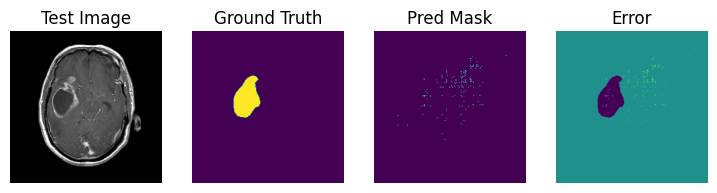

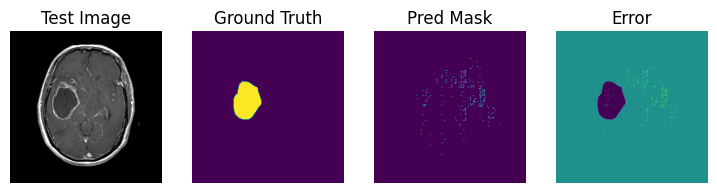

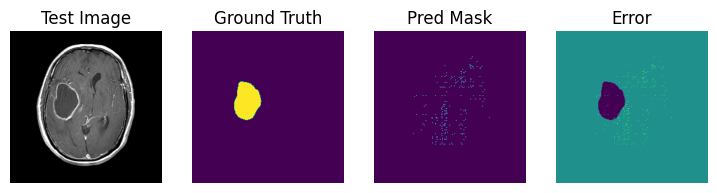

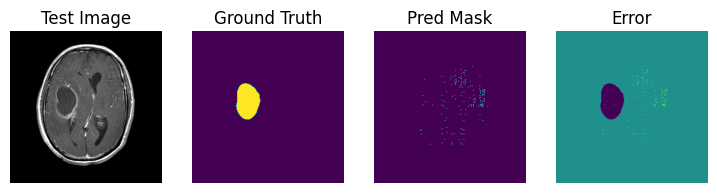

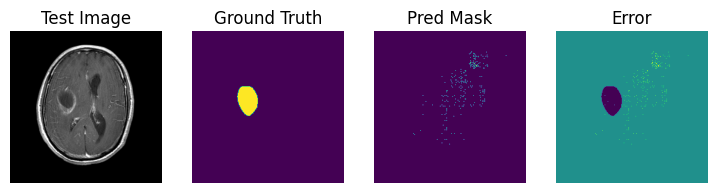

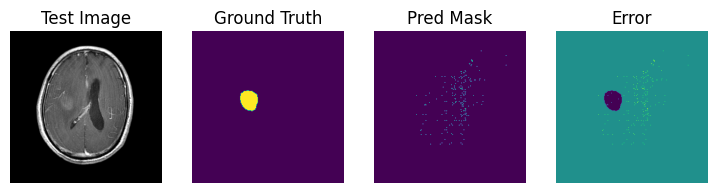

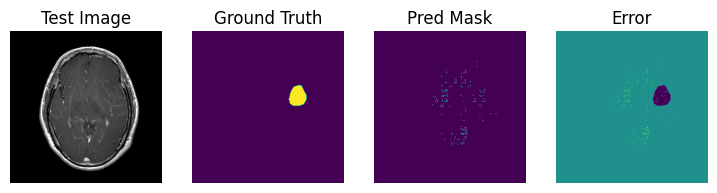

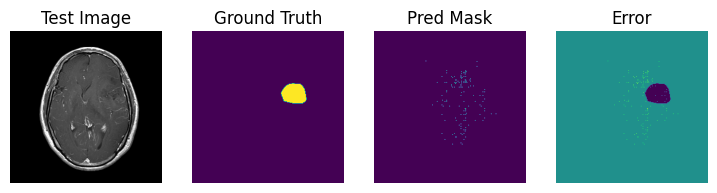

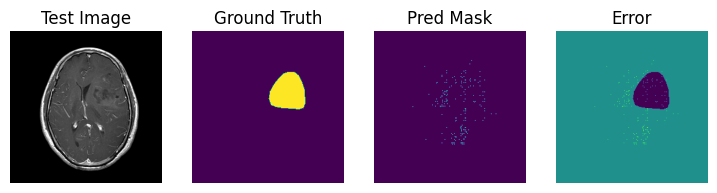

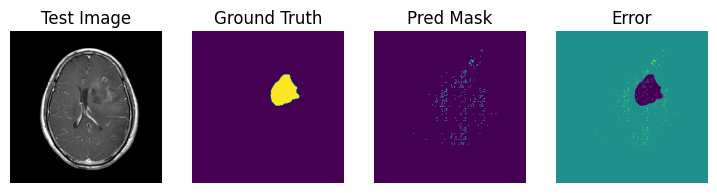

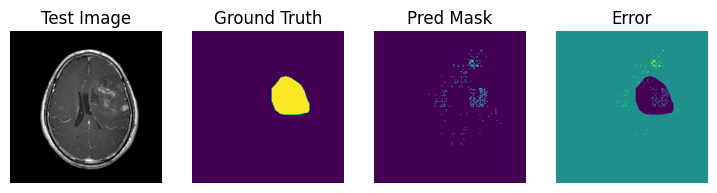

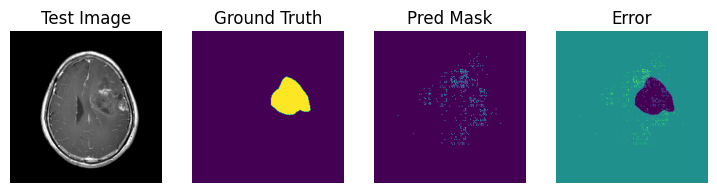

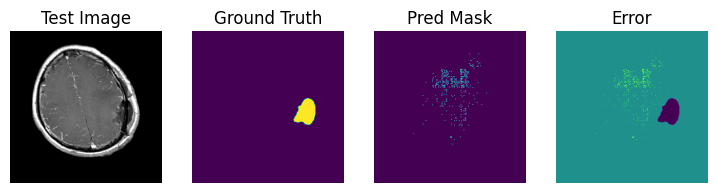

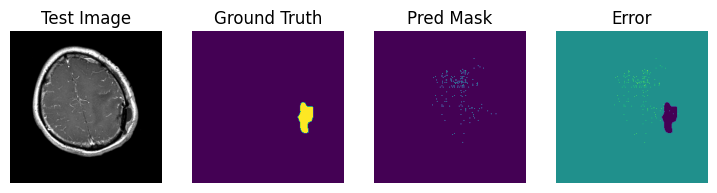

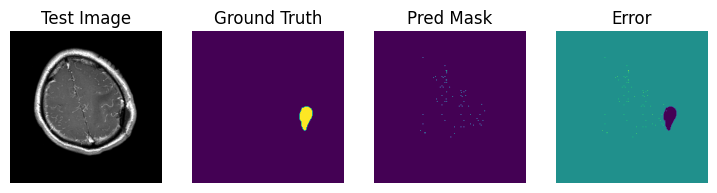

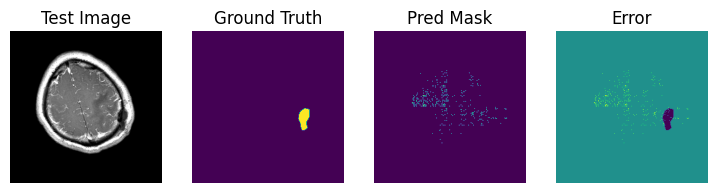

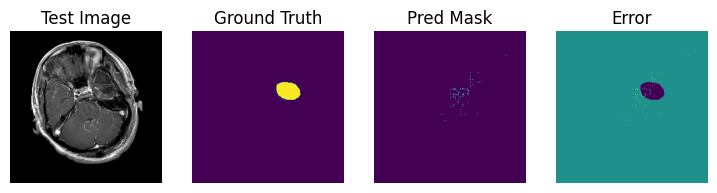

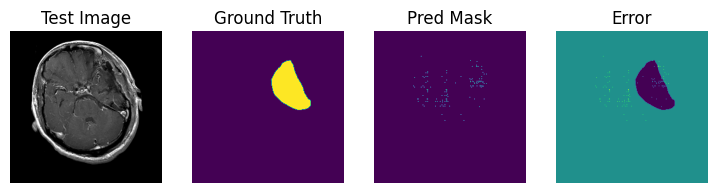

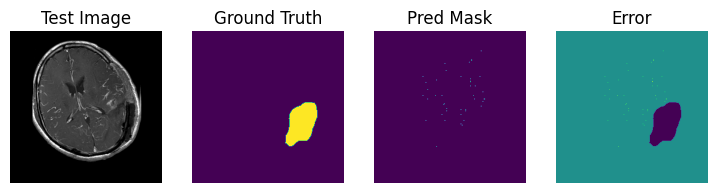

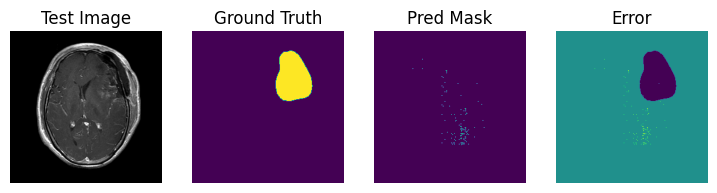

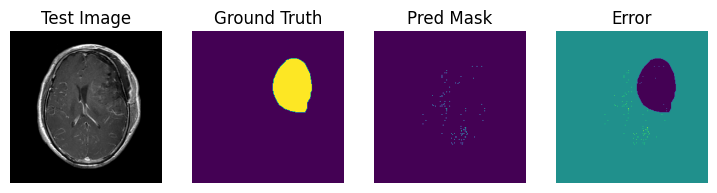

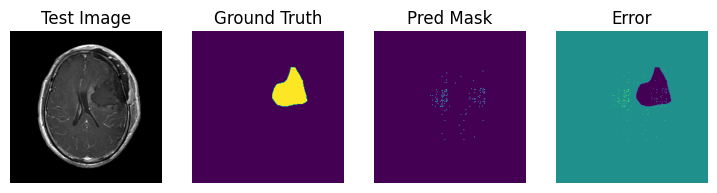

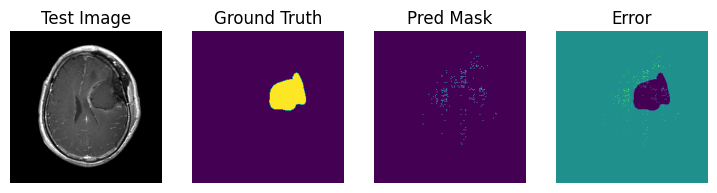

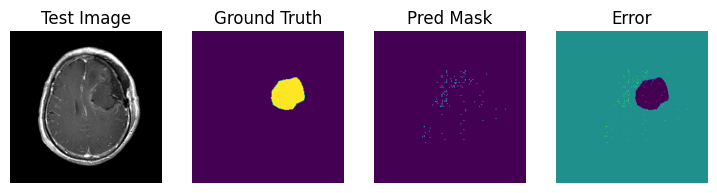

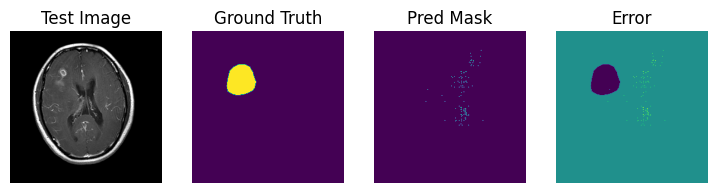

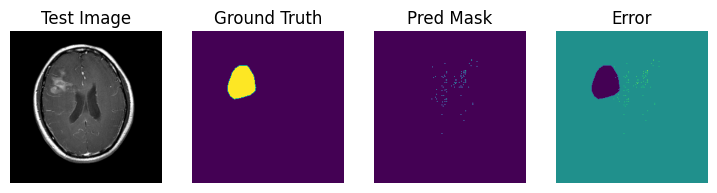

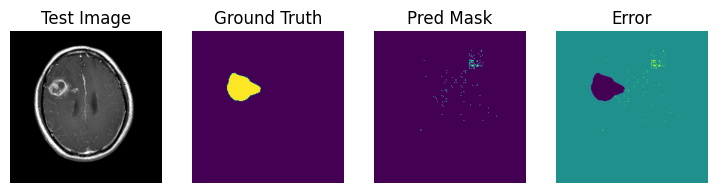

In [31]:
for i in range(27):
    
    img = imgs_test[i]
    msk = np.argmax(imgs_id_t_[i], axis=2)*255
    pred = np.argmax(imgs_mask_test[i], axis=2)*255
#     msk = imgs_id_t_[i]
#     pred = imgs_mask_test[i]
#     msk = imgs_id_t_[i, ..., 1]
#     pred = imgs_mask_test[i, ..., 1]
    error = pred - msk

    fig, ax = plt.subplots(1, 4, figsize=(9,4))
    ax[0].imshow(img.astype("int"))
    ax[0].set_title("Test Image")
    ax[0].set_axis_off()
    ax[1].imshow(msk)
    ax[1].set_title("Ground Truth")
    ax[1].set_axis_off()
    ax[2].imshow(pred)
    ax[2].set_title("Pred Mask")
    ax[2].set_axis_off()
    ax[3].imshow(error)
    ax[3].set_title("Error")
    ax[3].set_axis_off()

    plt.show()